# Horizon dectection using clustering

In [101]:
import numpy as np
from sklearn.cluster import KMeans
from PIL import Image
import matplotlib.pyplot as plt
from scipy.misc import face
import sys
import cv2
import os

In [102]:
# We are doing a depth first search
sys.setrecursionlimit(30000)
num_clusters = 6

In [103]:
 def rgb2grayscale(im):
        """
            Converts RGB to Grayscale.
            @params: Input RGB image.
            @return: Grayscale image(1 channel)
        """
        if  len(im.shape) > 2:
            if im.shape[2] == 3: # Convert RGB image to Grayscale
                r, g, b = im[:, :, 0], im[:, :, 1], im[:, :, 2]
                grayscale = 0.2989 * r + 0.5870 * g + 0.1140 * b
                return grayscale
        else:
            return im


In [104]:
input_file = 'dynamic_programming/input/horizon25.jpg'
im = cv2.imread(input_file)
h,w,c = im.shape
# Resize image due to recursion limitation
while (h>400 or w > 400):
    im = cv2.resize(im, dsize=(w//2, h//2), interpolation=cv2.INTER_CUBIC)
    h,w,c = im.shape

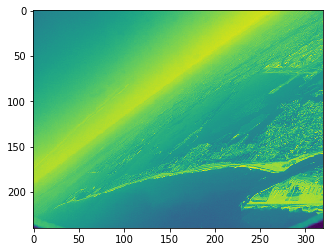

In [105]:
img  = rgb2grayscale(np.array(im))
width, height = img.shape
# flatten image
img_ = img.reshape(-1,1)
plt.imshow(img)

In [106]:
kmeans = KMeans(n_clusters=num_clusters).fit(img_)

In [107]:
values = kmeans.cluster_centers_.squeeze()
labels = kmeans.labels_

In [108]:
img_compressed = np.choose(labels, values)
img_compressed.shape = img.shape

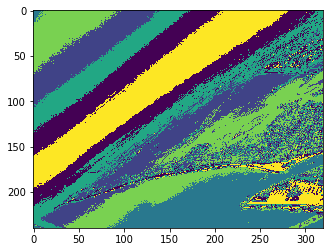

In [109]:
labels_reshaped = labels.reshape(width, height)
plt.imshow(labels_reshaped)

In [110]:
sub_clusters = np.zeros((width,height), dtype=np.uint32)

cnt=1
for j in range(height):
    for i in range(width):
        sub_clusters[i,j]=cnt
        cnt +=1
sub_clusters.shape

(240, 320)

In [111]:
visited =  np.zeros((width, height), dtype=bool)

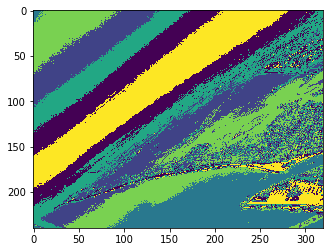

In [112]:
plt.imshow(labels_reshaped)

In [113]:
def connect_labels(x, y, in_labels):
    visited[x,y] = True
    #print(x,y)
    if not in_labels[x,y]:
        return
    for i in range(-1,2):
        for j in range(-1,2):
            if x+i > 0 and x+i < width and y+j > 0 and y+j < height and not(i==0 and j==0):
                if not visited[x+i,y+j]:
                    if in_labels[x,y] == in_labels[x+i,y+j]:
                    #if labels_reshaped[x,y] == labels_reshaped[x+i,y+j]:
                        sub_clusters[x+i,y+j] = sub_clusters[x,y]
                        connect_labels(x+i, y+j, in_labels)

In [114]:
for l in range(6):
    in_labels = labels_reshaped==l
    visited =  np.zeros((width, height), dtype=bool)
    for i in range(width):
        for j in range(height):
            if not visited[i,j]:
                connect_labels(i,j, in_labels)

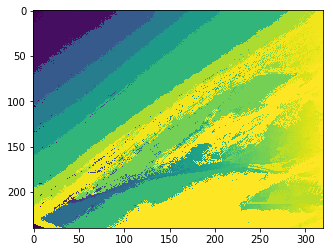

In [115]:
plt.imshow(sub_clusters)

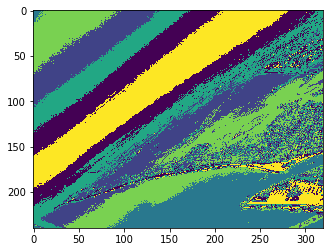

In [116]:
plt.imshow(labels_reshaped)

In [117]:
d = {}
for sub_cluster_val in np.unique(sub_clusters):
    sub_cluster_sample = sub_clusters==sub_cluster_val
    num_pixels = np.sum(sub_cluster_sample).astype(np.uint32)
    width_check = np.zeros((1,height),dtype=np.uint16)
    for row in range(width):
        width_check = np.bitwise_or(width_check,sub_cluster_sample[row,:])
    
    d[str(sub_cluster_val)] = (num_pixels,np.sum(width_check),np.sum(width_check)/num_pixels)

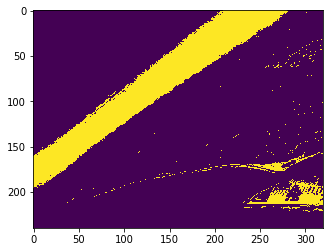

In [118]:
plt.imshow(labels_reshaped==5)

In [119]:
min_pixels = width*height
horizon = []
_max = 0
for k in d.keys():
    if d[k][2]*d[k][1] > _max and not d[k][2] == 1:
        _max = d[k][2]*d[k][1]
        sol = k

In [120]:
print(_max)

21.752941176470586


In [121]:
#for k in d.keys():
#    if d[k][1] > max_width*1//2:
#        horizon.append(int(k))
#        if d[k][0] < min_pixels:
#            min_pixels = d[k][0]

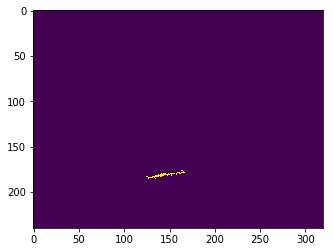

In [122]:
plt.imshow(sub_clusters == int(sol))

In [123]:
for i in range(width):
    for j in range(height):
        if (sub_clusters == int(sol))[i,j]:
            im[i,j,2] = 255

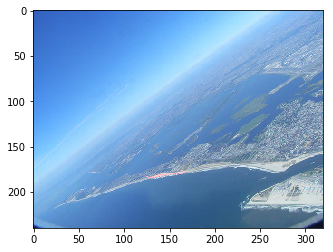

In [124]:
plt.imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))

In [125]:
outfile = 'dynamic_programming/out/'+input_file.split('/')[2].split('.')[0]+'_cluster.jpg'
plt.imsave(outfile, cv2.cvtColor(im, cv2.COLOR_BGR2RGB))